## Import Things so the Code Runs
(Adjust your drive path!)

In [1]:
drive = False  # False for Local
if drive:
    !pip install pretty_midi
    !pip install -U sparsemax
# locally, also compile torch with CUDA enabled:
# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 cudatoolkit=11.3 -c pytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
#this package is used to write it back into music.
from mido import Message, MidiFile, MidiTrack
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import torch.distributions
import sparsemax

In [3]:
if drive:
    from google.colab import drive
    drive.mount('/content/drive')
    my_drive_path = '/content/drive/MyDrive/2022_Special_Studies_Hablutzel/ModelCopies/'
else: # local
    my_drive_path = "./"

## Load Data

In [4]:
# load the data; in these small-scale tests I usually loaded the val data because it didn't take as long to load. When you are training, load the train data.
data = torch.load(my_drive_path + "usable_data/train_tempo_round_down_30.csv")  # truncate rather than padding w/ silence
# data = torch.load(my_drive_path + "usable_data/train_tempo_all_w_beats_30.csv")  # pad w/ silence at the end
# data = torch.load(my_drive_path + "usable_data/validationn_tempo_round_down_30.csv")  # load val data for small-scale tests

torch.manual_seed(2022)

## Helper Functions

In [5]:
#this function takes in the piece of music and returns the chroma vectors
def get_chroma(roll, length):
    chroma_matrix = torch.zeros((roll.size()[0],12))
    for note in range(0, 12):
        chroma_matrix[:, note] = torch.sum(roll[:, note::12], axis=1)
    return chroma_matrix

In [6]:
#this takes in the sequence and creates a self-similarity matrix (it calls chroma function inside)
def SSM(sequence):
  #tensor will be in form length, hidden_size (128)
  cos = nn.CosineSimilarity(dim=1)
  chrom = get_chroma(sequence, sequence.size()[0])
  len = chrom.size()[0]
  SSM=torch.zeros((len, len))
  for i in range(0, len):
    SSM[i] = cos(chrom[i].view(1, -1),chrom)
  return (SSM)

In [7]:
#this bundles the SSM function.
def batch_SSM(seq, batch_size):
  # takes sequence in format
  # [beats=400, batch_size, 128]
  # print("SSM\tsequence_shape", seq.shape)
  SSMs = []
  for i in range(0, batch_size):
    # print("SSM\tsequence", seq[:,i,:].shape)
    ssm = SSM(seq[:,i,:])  # [beats, batch, 128]
    # print("SSM\tssm", ssm.shape)
    SSMs.append(ssm)  
  return torch.vstack(SSMs)

In [8]:
# Takes in the batch size and data and returns batches of the batch size
def make_batches(data, batch_size, piece_size=800):
  random.shuffle(data)
  batches = []
  if batch_size > 1:  # make batches
    num_batches = len(data)//batch_size
    for i in range(0, num_batches):
      batch = torch.cat(list(np.array(data)[i*batch_size: (i+1)*(batch_size)][:, 0])).view(batch_size, piece_size, 128)
      batches.append(batch)
  else:  # each piece is its own batch - doesn't use passed-in piece_size
    for i in range(len(data)):
      # removes tempo info from data, but leaves 1 piece per batch
      piece_size = data[i][0].shape[0]
      batch = data[i][0].view(1, piece_size, 128)
      batches.append(batch)
      # print(batches[i])
  # print(batches)
  return batches

In [9]:
# returns batches where piece size is constant within the batch
# but piece size is different across batches
# and batches are in random order
def make_variable_size_batches(data, min_batch_size=10):
  # sort data by num beats (element at index 2 in each sublist)
  data.sort(key = lambda x: x[2], reverse=False)  # sort descending

  # split data into batches, where each batch contains pieces of the same size
  batches = []

  i = 0  # counter of pieces
  
  while i < len(data):
    this_batch = []
    pieces_this_batch = 0
    current_beats = data[i][2] # num beats in this batch

    # for all pieces with this # of beats
    while i < len(data) and data[i][2] == current_beats:
      # get tensor from row of data, and reshape 
      just_tensor = data[i][0].view(1, data[i][0].shape[0], 128)  
      this_batch.append(just_tensor)

      # increment counters
      i += 1
      pieces_this_batch += 1

    # print("this batch", this_batch)
    # print("shapes in batch")
    # for p in this_batch:
      # print("\t", p.shape)
        
    # only save large enough batches
    if pieces_this_batch >= min_batch_size:
        # reformat pieces in this batch into one tensor of size [batch size, beats, 128]
        batch = torch.cat(this_batch, dim=0)

        # store batch
        batches.append(batch)

    # clean up variables
    del this_batch
    del pieces_this_batch
    del current_beats

  # randomize batches order
  random.shuffle(batches)

  return batches

In [10]:
#sampling function 
def topk_sample_one(sequence, k):
  #takes in size sequence length, batch size, values
  softmax = sparsemax.Sparsemax(dim=2)
  vals, indices = torch.topk(sequence[:, :, 20:108],k)
  indices+=20
  seq = torch.distributions.Categorical(softmax(vals.float()))
  samples = seq.sample()
  onehot = F.one_hot(torch.gather(indices, -1, samples.unsqueeze(-1)), num_classes = sequence.shape[2]).squeeze(dim=2)
  return(onehot)

In [11]:
#samples multiple times for the time-step
def topk_batch_sample(sequence, k):
  for i in range(0, 3):
    new= topk_sample_one(sequence, k)
    if i ==0:
      sum = new
    else:
      sum+=new
  return(torch.where(sum>0, 1, 0))


In [12]:
def custom_loss(output, target):
  #custom loss function
  criterion = nn.BCEWithLogitsLoss()
  weighted_mse = criterion(output.double(), target.double())
  batch_size = output.size()[1]
  ssm_err = 0
  for i in range(0, batch_size):
    SSM1 = SSM(output[:,i,:])
    SSM2 = SSM(target[:,i,:])
    ssm_err += (torch.sum((SSM1-SSM2)**2)/(SSM2.size(0)**2))


  return torch.sum(weighted_mse)+ssm_err

## The Model

In [13]:
# this is the model
class music_generator(nn.Module):
    def __init__(self, hidden_size, output_size, base_lstm=False):
        super().__init__()
        self.hidden_size = hidden_size  # 128
        # output_size is num expected features (128)
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers=1, bidirectional=False)
        self.attention = nn.Linear(2, 1)
        self.softmax = sparsemax.Sparsemax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.hidden = None
        self.base_lstm = base_lstm  # true to use lstm without attention

    def init_hidden(self, batch_size):
        # set hidden state to zeros after each batch
        hidden = (torch.zeros(1, batch_size, self.hidden_size)).float() # .to("cuda:0")  # [layers, batch_size, hidden_size/features]
        self.hidden = (hidden, hidden) # hidden_state, cell_state
        return

    def set_random_hidden(self, batch_size):
        # create new random hidden layer
        hidden = (torch.randn(1, batch_size, self.hidden_size)).float() # .to("cuda:0")
        self.hidden = (hidden, hidden)
        return

    def forward(self, in_put, batch_size, prev_sequence, batched_ssm):
        # look at tensor things - view vs. reshape vs. permute, and unsqueeze and squeeze
        # try looking at the LSTM equations
        # .to('cpu')  # returns a copy of the tensor in CPU memory
        # .to('cuda:0')  # returns copy in CUDA memory, 0 indicates first GPU device
        # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.to

        # sequence length
        # size of input (10 or 1)
        sequence_length = in_put.size()[0]
        # print("in_put:", in_put.shape)

        # Run the LSTM
        # output - sequence of all the hidden states
        # hidden - most recent hidden state
        # input dimensions: [sequence_length, batch_size, 128]
        output, self.hidden = self.lstm(in_put.float(), self.hidden) # removed input.tocuda, so hidden doesn't need cuda either # make sure hidden in cuda memory! - #0].to("cuda:0").float(), hidden[1].to("cuda:0").float()))
        # output dimensions: [sequence_length, batch_size, 128]
        # outputs as many beats (sequence_length) as there were beats in the input
        # hidden: last hidden states from last beat

        #########################
        # attention starts here #
        #########################
        
        # output without attention
        new_output = output.view(sequence_length, batch_size, 1, 128)  # reshape
        avg_output = torch.sum(new_output, 2)
        
        # if we're using a starter sequence, cut output to last note
        avg_output = avg_output[-1,:,:].unsqueeze(1)  # [batch_size, 1, 128]
        
        # return early (w/o attention) for base lstm
        if self.base_lstm:
          return avg_output.transpose(0,1), self.hidden
        
        #this variable holds the output after the attention has been applied.
        seqs = []

        # slice the batched ssms to the right places
        beat_num = prev_sequence.shape[0]
        
        # find the row for this beat in each ssm
        # batched_ssm shape is (batch_size*beats, beats), bc all the pieces are stacked vertically atop each other
        inds_across_pieces = range(beat_num, batched_ssm.shape[0], batched_ssm.shape[1])  # eg 11, 2625, 105 - indices of this beat in each of the pieces in the batched_ssm
        
        # for the row for this beat in each ssm, slice the row up to (not including) this beat
        ssm_slice = batched_ssm[inds_across_pieces, :beat_num] # [batch_size, beat_num]
        
        # sparsemax makes entries in the vector add to 1
        weights = self.softmax(ssm_slice)  # weights are shape [batch_size, beat_num]

        # this is the sparsemaxed SSM multiplied by the entire previous sequence
        # to scale the previous timesteps for how much attention to pay to each
        # TODO: replace .T
        weighted = (prev_sequence.T*weights).T  # [batch_size, beat_num]

        # then it's summed to provide weights for each note.
        weight_vec = (torch.sum(weighted, axis=0)).unsqueeze(1)  # [batch_size, 1, 128]

        # This concatenates the weights for each note with the output for that note, which is then run through the linear layer to get the final output.
        # returns attentioned note
        pt2 = torch.hstack((weight_vec, avg_output)).transpose(1,2)
        attentioned = self.attention(pt2.float()).permute(2,0,1)  # before .permute() .to("cuda:0")).to('cpu')

        # delete vars to remove clutter in memory
        del pt2
        del weight_vec
        del weighted
        del weights
        del ssm_slice
        del inds_across_pieces
        del beat_num
        del new_output
        del avg_output

        # return attentioned note
        return attentioned.double(), self.hidden  # hidden = hidden_state, cell_state

## For Training the Model and Generating Sequences

In [14]:
class model_trainer():
  def __init__(self, generator, optimizer, data, hidden_size=128, batch_size=50):
    self.generator = generator
    self.optimizer = optimizer
    self.batch_size = batch_size  # play with this
    self.hidden_size = hidden_size  # 128
    self.data = data
    self.data_length = data[0][0].shape[0]  # as long as piece length doesn't vary

  def train_epochs(self, num_epochs=50, full_training=False, variable_size_batches=False, save_name="model"):
    #trains each epoch
    losslist = []
    #useful when you want to see the progression of the SSM over time
    piclist = []

    for iter in tqdm(range(0, num_epochs)):
      # start training the generator
      self.generator.train()

      if variable_size_batches:
        # use all data, and group batches by piece size
        batches = make_variable_size_batches(self.data)
      elif full_training and not variable_size_batches: # truncating data doesn't work w/ variable size batches currently
        # use all data
        batches = make_batches(self.data, self.batch_size, self.data_length)
      else:
        # use first 100 pieces
        # can we overfit on a small dataset? if so, can be a good thing b/c shows the model can learn
        batches = make_batches(self.data[:100], self.batch_size, self.data_length)

      cum_loss = 0
      for batch_num in tqdm(range(len(batches))):
        batch = batches[batch_num]
        if full_training:
          # train on full-length pieces
          loss = self.train(batch)
        else:
          # train on first 105 beats of each piece
          loss = self.train(batch[:,:105,:])  # [batch, beats, 128]
        cum_loss+=loss
        del batch
        del loss
      del batches
          
      # print loss for early stopping
      print(cum_loss)
    
      # save generator after each epoch
      curr_file = f"{my_drive_path}trained/{save_name}-epoch-{str(iter)}-loss-{cum_loss:.5f}.txt"
      # !touch curr_file
      torch.save(self.generator, curr_file)

      # generate example piece for piclist
      snap = self.generate_n_examples(n=1, length=95, starter_notes=10)

      losslist.append(cum_loss) 
      piclist.append(snap)
      del snap
        
      # early stopping:
      # after each epoch,
      # run w/ validation
      # if devset (validation) loss goes up for ~5 epochs in a row, early stopping
    return losslist, piclist

  # train for one batch
  def train(self, batch, starter_notes=10):
    # seed vectors for the beginning:
    batch_size = batch.shape[0]
    self_sim = batch_SSM(batch.transpose(0,1), batch_size)  # use variable batch size
    sequence = batch[:,0:starter_notes,:].transpose(0,1)  # start w/ some amount of the piece - 10 might be a bit much
    generated = batch[:,0:starter_notes,:].transpose(0,1)

    # reset hidden to zeros for each batch
    self.generator.init_hidden(batch_size)
        
    # zero the gradients before training for each batch
    self.optimizer.zero_grad()
    
    # for accumulating loss
    loss = 0

    # first .forward on sequence of num_starter_beats (~5 or 10 or so)
    # then loop from there to generate one more element
    next_element = sequence.to("cpu")  # make copy!

    # take
    for i in range(0,batch.shape[1]-starter_notes):  # for each beat
      # iterate through beats, generating for each piece in the batch as you go
      val = torch.rand(1)  # probability it uses original - teacher forcing

      # generate a beat for each piece in the batch
      # we need to do this even in cases of teacher forcing, so we can calculate loss
      output, _ = self.generator.forward(next_element, batch_size, sequence, self_sim)  # returns output, hidden - we don't need the latest copy of hidden
      # print("outside output:", output.shape)
        
      if (val > .8):
        # teacher forcing - 20% of the time,  use original from piece instead of output
        next_element = batch[:,i+1,:].unsqueeze(0)  # [1, 0/deleted, 128] to [1, 1, 128]
      else:
        # 80% of the time we keep the output
        # take last output for each batch
        next_element = topk_batch_sample(output, 5) # sample up to 5 most likely notes at this beat
      
      # add next_element (either generated or teacher) to sequence
      sequence = torch.vstack((sequence, next_element.to("cpu"))) # .unsqueeze(0)
      # append output (generated - not teacher forced) for loss
      generated = torch.vstack((generated, output))  # used for loss
    
    # run loss after training on whole length of the pieces in the batches
    single_loss = custom_loss(generated[starter_notes:,:,:], batch.transpose(0,1)[starter_notes:,:,:])
    single_loss.backward()

    # update the parameters of the LSTM after running on full batch
    self.optimizer.step()

    loss += single_loss.detach().to('cpu')
    del next_element
    del self_sim
    del sequence
    del generated
    del single_loss
    return (loss)

#   def generate_n_pieces_old(self, initial_vectors, n_pieces, length, batched_ssm):
#     # generates a batch of n new pieces of music

#     # freeze generator so it doesn't train anymore
#     self.generator.eval()  
#     # start generator on random hidden states and cell states
#     self.generator.set_random_hidden(n_pieces)
  
#     # initial vectors in format [batch_size, num_notes=10, 128]
#     # change sequence to [10, batch_size, 128]
#     sequence = initial_vectors.transpose(0,1)
    
#     # can't generate more notes than the ssm
#     max_notes = batched_ssm.shape[0]
    
#     # generate [length] more beats for the piece
#     for i in range(0, min(length, max_notes)):  # one at a time
#       print(i)
#       with torch.no_grad():
#         # use n_pieces to generate as the batch size
#         output, _ = self.generator.forward(sequence.float(), n_pieces, sequence, batched_ssm)
#         next_element = topk_batch_sample(output, 5)  # sample up to 5 most likely notes at this beat
#       # add element to sequence
#       sequence = torch.vstack((sequence, next_element.to("cpu")))

#     # return sequence of beats
#     return sequence

  def generate_n_pieces(self, initial_vectors, n_pieces, length, batched_ssm):
    # generates a batch of n new pieces of music

    # freeze generator so it doesn't train anymore
    self.generator.eval()  
    # start generator on random hidden states and cell states
    self.generator.set_random_hidden(n_pieces)
  
    # initial vectors in format [batch_size, num_notes=10, 128]
    # change sequence to [10, batch_size, 128]
    sequence = initial_vectors.transpose(0,1)
    next_element = sequence.to("cpu")

    # can't generate more notes than the ssm has entries
    max_notes = batched_ssm.shape[0]-sequence.shape[0]
    
    # generate [length] more beats for the piece
    # or as many beats as available in the ssm
    for i in range(min(length, max_notes)):  # one at a time
      with torch.no_grad():
        # use n_pieces to generate as the batch size
        output, _ = self.generator.forward(next_element.float(), n_pieces, sequence, batched_ssm)
        next_element = topk_batch_sample(output, 5)  # sample up to 5 most likely notes at this beat
      # add element to sequence
      sequence = torch.vstack((sequence, next_element.to("cpu")))

    # return sequence of beats
    return sequence
  
#   def generate_n_examples_old(self, n=1, length=390, starter_notes=10, source_piece=0):
#     # get piece from the data
#     piece = self.data[source_piece][0].unsqueeze(0)  # in format [1, 400, 128]

#     # take first 10 notes in format [1, 10, 128]
#     first_vec = piece[:,0:starter_notes,:]

#     # create batched SSMs for each piece
#     batched_ssms = batch_SSM(piece.transpose(0,1), n)

#     # generate pieces
#     new_gen = self.generate_n_pieces(first_vec, n, length, batched_ssms)

#     # clean up variables
#     del piece
#     del first_vec
#     del batched_ssms

#     # return pieces
#     return new_gen

  def generate_n_examples(self, n=1, length=390, starter_notes=10, piece_inds=[0], random_source_pieces=False):
    # get pieces from the data
    pieces = torch.vstack([self.data[i][0].unsqueeze(0) for i in piece_inds]) # get just the note for each piece, and stack pieces
    
    # print(pieces.shape)

    # take first 10 notes in format [1, 10, 128]
    first_vecs = pieces[:,0:starter_notes,:]

    # create batched SSMs for each piece
    batched_ssms = batch_SSM(pieces.transpose(0,1), n)

    # generate pieces
    new_gen = self.generate_n_pieces(first_vecs, n, length, batched_ssms)

    # clean up variables
    del pieces
    del first_vecs
    del batched_ssms

    # return pieces
    return new_gen



## Train Model Here

In [15]:
# # create model and optimizer
generator = music_generator(128,128) # .to("cuda:0")  # try without cuda
optimizer = torch.optim.Adam(generator.parameters(), lr=0.005)

# parameters
hidden_size = 128  # maybe don't touch?
# batch_size = 10     # set to 1 for variable-size pieces
# target_size = 800  # make this not global?

# model trainer
trainer = model_trainer(generator, optimizer, data, hidden_size)

In [16]:
# train the model

# with variable-size batches:
# was going to take 7 hours an epoch on the lab computer (186-ish batches)
# min batch size 5 was 76 batches, ~2 hours an epoch
# min batch size 10 is 40 batches, ~1 hour an epoch? 30 min an epoch? much shorter

# changes batches to let piece size vary
losslist, piclist = trainer.train_epochs(num_epochs=30,
                                         full_training=True,
                                         variable_size_batches=True
                                        )

  0%|          | 0/41 [00:00<?, ?it/s]<ipython-input-13-1877afbe48f8>:81: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  weighted = (prev_sequence.T*weights).T  # [batch_size, beat_num]

  3%|▎         | 1/30 [37:03<17:54:33, 2223.23s/it]

tensor(379.0628, dtype=torch.float64)



  7%|▋         | 2/30 [1:14:24<17:22:20, 2233.60s/it]

tensor(374.5075, dtype=torch.float64)



 10%|█         | 3/30 [1:51:36<16:44:56, 2233.19s/it]

tensor(371.6198, dtype=torch.float64)



 13%|█▎        | 4/30 [2:29:00<16:09:34, 2237.50s/it]

tensor(369.7007, dtype=torch.float64)



 17%|█▋        | 5/30 [3:06:20<15:32:39, 2238.38s/it]

tensor(368.4423, dtype=torch.float64)



 20%|██        | 6/30 [3:43:43<14:55:57, 2239.88s/it]

tensor(367.5753, dtype=torch.float64)



 23%|██▎       | 7/30 [4:21:13<14:19:52, 2243.14s/it]

tensor(366.9223, dtype=torch.float64)



 27%|██▋       | 8/30 [4:58:38<13:42:40, 2243.65s/it]

tensor(366.4817, dtype=torch.float64)



 30%|███       | 9/30 [5:36:04<13:05:34, 2244.50s/it]

tensor(366.1253, dtype=torch.float64)



 33%|███▎      | 10/30 [6:13:28<12:28:06, 2244.31s/it]

tensor(365.8709, dtype=torch.float64)



 37%|███▋      | 11/30 [6:50:47<11:50:14, 2242.84s/it]

tensor(365.6858, dtype=torch.float64)



 40%|████      | 12/30 [7:28:17<11:13:26, 2244.79s/it]

tensor(365.5431, dtype=torch.float64)



 43%|████▎     | 13/30 [8:05:43<10:36:10, 2245.33s/it]

tensor(365.4240, dtype=torch.float64)



 47%|████▋     | 14/30 [8:43:12<9:59:01, 2246.37s/it] 

tensor(365.3036, dtype=torch.float64)



 50%|█████     | 15/30 [9:20:38<9:21:31, 2246.13s/it]

tensor(365.1539, dtype=torch.float64)



 53%|█████▎    | 16/30 [9:58:01<8:43:52, 2245.18s/it]

tensor(364.9554, dtype=torch.float64)



 57%|█████▋    | 17/30 [10:35:27<8:06:33, 2245.68s/it]

tensor(364.5856, dtype=torch.float64)



 60%|██████    | 18/30 [11:12:52<7:29:02, 2245.22s/it]

tensor(363.8883, dtype=torch.float64)



 63%|██████▎   | 19/30 [11:50:16<6:51:36, 2245.11s/it]

tensor(360.3787, dtype=torch.float64)



 67%|██████▋   | 20/30 [12:27:41<6:14:10, 2245.05s/it]

tensor(330.9595, dtype=torch.float64)



 70%|███████   | 21/30 [13:05:04<5:36:39, 2244.37s/it]

tensor(304.5692, dtype=torch.float64)



 73%|███████▎  | 22/30 [13:42:26<4:59:09, 2243.72s/it]

tensor(339.5851, dtype=torch.float64)



100%|██████████| 41/41 [37:28<00:00, 54.84s/it]


tensor(279.5868, dtype=torch.float64)


 80%|████████  | 24/30 [14:57:38<3:45:02, 2250.48s/it]

tensor(332.6852, dtype=torch.float64)



 83%|████████▎ | 25/30 [15:35:11<3:07:35, 2251.19s/it]

tensor(380.8822, dtype=torch.float64)



 87%|████████▋ | 26/30 [16:12:28<2:29:47, 2246.91s/it]

tensor(378.8396, dtype=torch.float64)



 90%|█████████ | 27/30 [16:49:23<1:51:52, 2237.53s/it]

tensor(377.2392, dtype=torch.float64)



 93%|█████████▎| 28/30 [17:26:01<1:14:11, 2225.65s/it]

tensor(375.9536, dtype=torch.float64)



 97%|█████████▋| 29/30 [18:02:37<36:56, 2216.83s/it]  

tensor(374.6709, dtype=torch.float64)



100%|██████████| 30/30 [18:39:12<00:00, 2238.42s/it]

tensor(372.5512, dtype=torch.float64)


In [17]:
#this code can save a model if you need it
# !touch my_drive_path+"model_final.txt"
torch.save(generator, my_drive_path + "trained/model_final_v3.txt" )

In [18]:
# create LSTM model and optimizer
generator_lstm = music_generator(128,128, base_lstm=True) # .to("cuda:0")  # try without cuda
optimizer_lstm = torch.optim.Adam(generator_lstm.parameters(), lr=0.005)

# parameters
hidden_size = 128  # maybe don't touch?
# batch_size = 10     # set to 1 for variable-size pieces
# target_size = 800  # make this not global?

# model trainer
trainer_lstm = model_trainer(generator_lstm, optimizer_lstm, data, hidden_size)

In [19]:
# train LSTM model
losslist_lstm, piclist_lstm = trainer_lstm.train_epochs(num_epochs=30,
                                                        full_training=True,
                                                        variable_size_batches=True,
                                                        save_name="model_lstm")

  3%|▎         | 1/30 [32:12<15:33:50, 1932.07s/it]

tensor(108.5115, dtype=torch.float64)



  7%|▋         | 2/30 [1:04:26<15:02:10, 1933.23s/it]

tensor(98.1385, dtype=torch.float64)



 10%|█         | 3/30 [1:36:38<14:29:52, 1933.04s/it]

tensor(95.6348, dtype=torch.float64)



 13%|█▎        | 4/30 [2:08:51<13:57:33, 1932.83s/it]

tensor(95.2786, dtype=torch.float64)



 17%|█▋        | 5/30 [2:41:04<13:25:24, 1932.99s/it]

tensor(94.5687, dtype=torch.float64)



 20%|██        | 6/30 [3:13:18<12:53:17, 1933.23s/it]

tensor(94.9274, dtype=torch.float64)



 23%|██▎       | 7/30 [3:45:21<12:19:49, 1929.98s/it]

tensor(95.3960, dtype=torch.float64)



 27%|██▋       | 8/30 [4:17:23<11:46:44, 1927.47s/it]

tensor(94.4698, dtype=torch.float64)



 30%|███       | 9/30 [4:49:25<11:14:01, 1925.77s/it]

tensor(94.0608, dtype=torch.float64)



 33%|███▎      | 10/30 [5:21:29<10:41:44, 1925.23s/it]

tensor(94.2398, dtype=torch.float64)



 37%|███▋      | 11/30 [5:53:05<10:06:47, 1916.17s/it]

tensor(94.1294, dtype=torch.float64)



 40%|████      | 12/30 [6:24:26<9:31:36, 1905.34s/it] 

tensor(93.8443, dtype=torch.float64)



 43%|████▎     | 13/30 [6:55:47<8:57:47, 1898.10s/it]

tensor(93.8986, dtype=torch.float64)



 47%|████▋     | 14/30 [7:27:08<8:24:49, 1893.07s/it]

tensor(93.7329, dtype=torch.float64)



 50%|█████     | 15/30 [7:58:29<7:52:19, 1889.33s/it]

tensor(94.3135, dtype=torch.float64)



 53%|█████▎    | 16/30 [8:29:55<7:20:34, 1888.16s/it]

tensor(94.3656, dtype=torch.float64)



 57%|█████▋    | 17/30 [9:01:26<6:49:19, 1889.20s/it]

tensor(94.0817, dtype=torch.float64)



 60%|██████    | 18/30 [9:33:00<6:18:07, 1890.66s/it]

tensor(93.6142, dtype=torch.float64)



 63%|██████▎   | 19/30 [10:04:35<5:46:50, 1891.87s/it]

tensor(93.7146, dtype=torch.float64)



 67%|██████▋   | 20/30 [10:36:16<5:15:45, 1894.53s/it]

tensor(93.4187, dtype=torch.float64)



 70%|███████   | 21/30 [11:07:57<4:44:28, 1896.49s/it]

tensor(93.2557, dtype=torch.float64)



 73%|███████▎  | 22/30 [11:39:37<4:13:01, 1897.73s/it]

tensor(93.9312, dtype=torch.float64)



 77%|███████▋  | 23/30 [12:11:22<3:41:38, 1899.80s/it]

tensor(93.2713, dtype=torch.float64)



 80%|████████  | 24/30 [12:43:02<3:09:59, 1899.88s/it]

tensor(93.2470, dtype=torch.float64)



 83%|████████▎ | 25/30 [13:14:44<2:38:22, 1900.52s/it]

tensor(93.2061, dtype=torch.float64)



 87%|████████▋ | 26/30 [13:46:20<2:06:36, 1899.16s/it]

tensor(93.0385, dtype=torch.float64)



 90%|█████████ | 27/30 [14:19:07<1:35:58, 1919.64s/it]

tensor(93.0773, dtype=torch.float64)



 93%|█████████▎| 28/30 [14:50:57<1:03:53, 1916.52s/it]

tensor(92.9526, dtype=torch.float64)



 97%|█████████▋| 29/30 [15:22:26<31:48, 1908.47s/it]  

tensor(93.1596, dtype=torch.float64)



100%|██████████| 30/30 [15:53:53<00:00, 1907.77s/it]

tensor(92.7669, dtype=torch.float64)


In [20]:
#this code can save a model if you need it
# !touch my_drive_path+"model_lstm_final.txt"
torch.save(generator_lstm, my_drive_path + "trained/model_lstm_final_v3.txt" )

## View Results and Generate Example

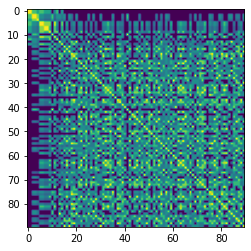

In [21]:
# view snapshots of pieces at each epoch
plt.imshow(SSM(piclist[-1].squeeze()))

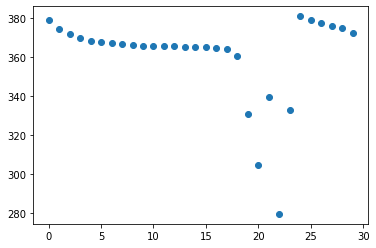

In [22]:
# show loss at each epoch
plt.scatter(range(0,len(losslist)), losslist)

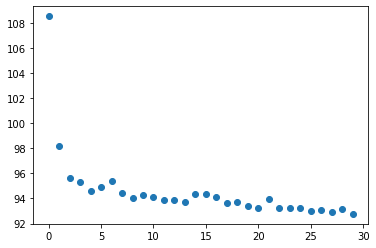

In [23]:
# show loss at each epoch - plain lstm
plt.scatter(range(0,len(losslist_lstm)), losslist_lstm)

In [24]:
# create example
# index = 0  # which source piece
# new_gen = trainer.generate_n_examples(n=2, length=390, starter_notes=10, source_piece=index)

In [25]:
# create example
indices = [-100]  # which source piece
new_gen = trainer.generate_n_examples(n=1, length=500, starter_notes=10, piece_inds=indices)

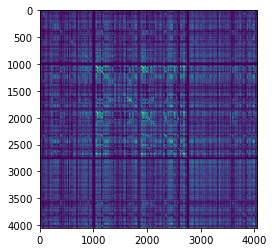

In [26]:
# show SSM for first piece
plt.imshow(SSM(data[indices[0]][0]))

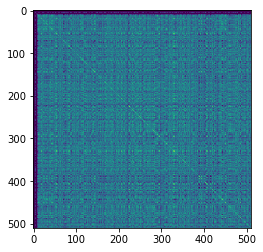

In [27]:
# show SSM for new piece
plt.imshow(SSM(new_gen.squeeze()))

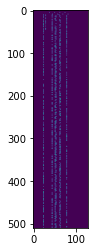

In [28]:
# show new piece
plt.imshow(new_gen.squeeze())

## Save Example Sequence to Audio

In [29]:
#this code translates the generated sequence to audio
def stop_note(note, time):
    return Message('note_off', note = note,
                   velocity = 0, time = time)

def start_note(note, time):
    return Message('note_on', note = note,
                   velocity = 120, time = time)

def roll_to_track(roll, tempo):
    delta = 0

    
    # MIDI note for first column.
    midi_base = 0
    notes = [0] * len(roll[0])
    for row in roll:
        for i, col in enumerate(row):
            note = i
            if col>notes[i] and col!=0: 
                if notes[i]!=0:
                    yield stop_note(note, delta)
                    delta = 0
                yield start_note(i, delta)
                delta = 0
                notes[i] = note
            elif col == 0:
                if notes[i]!=0:
                    # Stop the ringing note
                    yield stop_note(note, delta)
                    delta = 0
                notes[i] = 0
        # ms per row
        delta += int(np.round((1/(tempo/60))*1000))



In [30]:
new_roll_final = np.vstack((new_gen.squeeze(), np.zeros(128)))
midi = MidiFile(type = 1)
midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, data[indices[0]][1])))
midi.save(my_drive_path + 'audio_outputs/dec12_-100.midi')